Initial Data Exploration

In [1]:
#Import dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Read in CSV
raw_data_2022_mn_pm25 = "Data/2022_MN_PM_25.csv"
df_raw_2022_mn_pm25 = pd.read_csv(raw_data_2022_mn_pm25)

In [3]:
df_raw_2022_mn_pm25

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/02/2022,AQS,270031002,1,13.5,ug/m3 LC,54,Anoka County Airport,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,3,Anoka,45.13768,-93.207615
1,01/05/2022,AQS,270031002,1,3.9,ug/m3 LC,16,Anoka County Airport,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,3,Anoka,45.13768,-93.207615
2,01/08/2022,AQS,270031002,1,9.6,ug/m3 LC,40,Anoka County Airport,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,3,Anoka,45.13768,-93.207615
3,01/11/2022,AQS,270031002,1,6.7,ug/m3 LC,28,Anoka County Airport,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,3,Anoka,45.13768,-93.207615
4,01/14/2022,AQS,270031002,1,2.6,ug/m3 LC,11,Anoka County Airport,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,3,Anoka,45.13768,-93.207615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8547,12/25/2022,AQS,271713201,3,3.6,ug/m3 LC,15,St. Michael Elementary School,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,171,Wright,45.20916,-93.669210
8548,12/26/2022,AQS,271713201,3,3.6,ug/m3 LC,15,St. Michael Elementary School,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,171,Wright,45.20916,-93.669210
8549,12/27/2022,AQS,271713201,3,5.0,ug/m3 LC,21,St. Michael Elementary School,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,171,Wright,45.20916,-93.669210
8550,12/28/2022,AQS,271713201,3,8.7,ug/m3 LC,36,St. Michael Elementary School,1,100.0,88101,PM2.5 - Local Conditions,33460.0,"Minneapolis-St. Paul-Bloomington, MN-WI",27,Minnesota,171,Wright,45.20916,-93.669210


In [4]:
# Look at unique values for each column
df_raw_2022_mn_pm25.nunique()

Date                              365
Source                              2
Site ID                            25
POC                                 4
Daily Mean PM2.5 Concentration    275
UNITS                               1
DAILY_AQI_VALUE                    93
Site Name                          25
DAILY_OBS_COUNT                     1
PERCENT_COMPLETE                    1
AQS_PARAMETER_CODE                  2
AQS_PARAMETER_DESC                  2
CBSA_CODE                           8
CBSA_NAME                           8
STATE_CODE                          1
STATE                               1
COUNTY_CODE                        18
COUNTY                             18
SITE_LATITUDE                      25
SITE_LONGITUDE                     25
dtype: int64

In [5]:
# Drop unneeded columns
df_raw_2022_mn_pm25_dropped = df_raw_2022_mn_pm25.drop(columns = ["Source", "Site ID", "DAILY_OBS_COUNT", "PERCENT_COMPLETE", 
                                                                  "AQS_PARAMETER_CODE", "AQS_PARAMETER_DESC", "CBSA_CODE", 
                                                                  "CBSA_NAME", "COUNTY_CODE", "STATE_CODE", "STATE"])
df_raw_2022_mn_pm25_dropped

,Date,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/02/2022,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615
1,01/05/2022,1,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615
2,01/08/2022,1,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615
3,01/11/2022,1,6.7,ug/m3 LC,28,Anoka County Airport,Anoka,45.13768,-93.207615
4,01/14/2022,1,2.6,ug/m3 LC,11,Anoka County Airport,Anoka,45.13768,-93.207615
...,...,...,...,...,...,...,...,...,...
8547,12/25/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8548,12/26/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8549,12/27/2022,3,5.0,ug/m3 LC,21,St. Michael Elementary School,Wright,45.20916,-93.669210
8550,12/28/2022,3,8.7,ug/m3 LC,36,St. Michael Elementary School,Wright,45.20916,-93.669210


In [6]:
df_raw_2022_mn_pm25["Site Name"].value_counts()

Harding High School                     801
Apple Valley                            491
Anoka County Airport                    468
Andersen School                         458
Boundary Waters                         413
Southwest Minnesota Regional Airport    362
Ben Franklin School                     359
Leech Lake Nation:                      358
Fond du Lac Band                        356
Near Road I-35                          355
B.F. Pearson School                     355
Red Lake Nation                         355
Near Road I-35/I-94                     353
St. Michael Elementary School           349
U of M - Duluth                         348
Brainerd Lakes Regional Airport         343
FWS Wetland Management District         338
Grand Portage Band                      335
Virginia City Hall                      331
Laura MacArthur School                  312
Talahi School                           277
St. Louis Park City Hall                145
Ramsey Health Center            

In [7]:
df_raw_2022_mn_pm25_dropped.columns

Index(['Date', 'POC', 'Daily Mean PM2.5 Concentration', 'UNITS',
       'DAILY_AQI_VALUE', 'Site Name', 'COUNTY', 'SITE_LATITUDE',
       'SITE_LONGITUDE'],
      dtype='object')

In [8]:
# Rename columns
columns = {"Date": "Date", "POC": "POC", "Daily Mean PM2.5 Concentration": "Day_Mean_PM25_Conc", "UNITS": "Units", 
           "DAILY_AQI_VALUE":"Daily_AQI", "Site Name": "Site_Name", "COUNTY": "County", "SITE_LATITUDE": "Latitude",
          "SITE_LONGITUDE": "Longitude"}

df_raw_2022_mn_pm25_rename = df_raw_2022_mn_pm25_dropped.rename(columns = columns)
df_raw_2022_mn_pm25_rename

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude
0,01/02/2022,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615
1,01/05/2022,1,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615
2,01/08/2022,1,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615
3,01/11/2022,1,6.7,ug/m3 LC,28,Anoka County Airport,Anoka,45.13768,-93.207615
4,01/14/2022,1,2.6,ug/m3 LC,11,Anoka County Airport,Anoka,45.13768,-93.207615
...,...,...,...,...,...,...,...,...,...
8547,12/25/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8548,12/26/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8549,12/27/2022,3,5.0,ug/m3 LC,21,St. Michael Elementary School,Wright,45.20916,-93.669210
8550,12/28/2022,3,8.7,ug/m3 LC,36,St. Michael Elementary School,Wright,45.20916,-93.669210


In [9]:
# Add column "AQI_Concern" to reflect AQI category names
df_raw_2022_mn_pm25_rename["AQI_Concern"] = np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 50, "Good", 
                                                     np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 100, "Moderate", 
                                                              np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 150, "Unhealthy for Sensitive Groups", 
                                                                       np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 200, "Unhealthy", 
                                                                                np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 300, "Very Unhealthy", "Hazardous")))))

In [10]:
df_raw_2022_mn_pm25_rename

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
0,01/02/2022,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
1,01/05/2022,1,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615,Good
2,01/08/2022,1,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615,Good
3,01/11/2022,1,6.7,ug/m3 LC,28,Anoka County Airport,Anoka,45.13768,-93.207615,Good
4,01/14/2022,1,2.6,ug/m3 LC,11,Anoka County Airport,Anoka,45.13768,-93.207615,Good
...,...,...,...,...,...,...,...,...,...,...
8547,12/25/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210,Good
8548,12/26/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210,Good
8549,12/27/2022,3,5.0,ug/m3 LC,21,St. Michael Elementary School,Wright,45.20916,-93.669210,Good
8550,12/28/2022,3,8.7,ug/m3 LC,36,St. Michael Elementary School,Wright,45.20916,-93.669210,Good


In [11]:
df_raw_2022_mn_pm25_rename.dtypes

Date                   object
POC                     int64
Day_Mean_PM25_Conc    float64
Units                  object
Daily_AQI               int64
Site_Name              object
County                 object
Latitude              float64
Longitude             float64
AQI_Concern            object
dtype: object

In [12]:
# Change Date column to datetime
df_raw_2022_mn_pm25_rename["Date"] = pd.to_datetime(df_raw_2022_mn_pm25_rename["Date"])
df_raw_2022_mn_pm25_rename.dtypes

Date                  datetime64[ns]
POC                            int64
Day_Mean_PM25_Conc           float64
Units                         object
Daily_AQI                      int64
Site_Name                     object
County                        object
Latitude                     float64
Longitude                    float64
AQI_Concern                   object
dtype: object

In [13]:
df_raw_2022_mn_pm25_rename.groupby(["Site_Name"]).count()

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,County,Latitude,Longitude,AQI_Concern
Site_Name,,,,,,,,,
Andersen School,458,458,458,458,458,458,458,458,458
Anoka County Airport,468,468,468,468,468,468,468,468,468
Apple Valley,491,491,491,491,491,491,491,491,491
B.F. Pearson School,355,355,355,355,355,355,355,355,355
Ben Franklin School,359,359,359,359,359,359,359,359,359
Boundary Waters,413,413,413,413,413,413,413,413,413
Brainerd Lakes Regional Airport,343,343,343,343,343,343,343,343,343
FWS Wetland Management District,338,338,338,338,338,338,338,338,338
Fond du Lac Band,356,356,356,356,356,356,356,356,356


In [14]:
# Look at Anoka separately

anoka_2022_pm25 = df_raw_2022_mn_pm25_rename.loc[df_raw_2022_mn_pm25_rename["Site_Name"] == "Anoka County Airport"]
anoka_2022_pm25

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
0,2022-01-02,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
1,2022-01-05,1,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615,Good
2,2022-01-08,1,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615,Good
3,2022-01-11,1,6.7,ug/m3 LC,28,Anoka County Airport,Anoka,45.13768,-93.207615,Good
4,2022-01-14,1,2.6,ug/m3 LC,11,Anoka County Airport,Anoka,45.13768,-93.207615,Good
...,...,...,...,...,...,...,...,...,...,...
463,2022-12-19,3,9.8,ug/m3 LC,41,Anoka County Airport,Anoka,45.13768,-93.207615,Good
464,2022-12-20,3,7.0,ug/m3 LC,29,Anoka County Airport,Anoka,45.13768,-93.207615,Good
465,2022-12-21,3,8.0,ug/m3 LC,33,Anoka County Airport,Anoka,45.13768,-93.207615,Good
466,2022-12-22,3,4.3,ug/m3 LC,18,Anoka County Airport,Anoka,45.13768,-93.207615,Good


In [15]:
anoka_2022_pm25.loc[anoka_2022_pm25["Date"] == "2022-01-02"]

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
0,2022-01-02,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
120,2022-01-02,3,13.3,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate


In [16]:
anoka_2022_pm25_daily = anoka_2022_pm25[anoka_2022_pm25["POC"] == 3]
anoka_2022_pm25_daily

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
119,2022-01-01,3,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615,Good
120,2022-01-02,3,13.3,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
121,2022-01-03,3,11.7,ug/m3 LC,49,Anoka County Airport,Anoka,45.13768,-93.207615,Good
122,2022-01-04,3,14.5,ug/m3 LC,56,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
123,2022-01-05,3,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615,Good
...,...,...,...,...,...,...,...,...,...,...
463,2022-12-19,3,9.8,ug/m3 LC,41,Anoka County Airport,Anoka,45.13768,-93.207615,Good
464,2022-12-20,3,7.0,ug/m3 LC,29,Anoka County Airport,Anoka,45.13768,-93.207615,Good
465,2022-12-21,3,8.0,ug/m3 LC,33,Anoka County Airport,Anoka,45.13768,-93.207615,Good
466,2022-12-22,3,4.3,ug/m3 LC,18,Anoka County Airport,Anoka,45.13768,-93.207615,Good


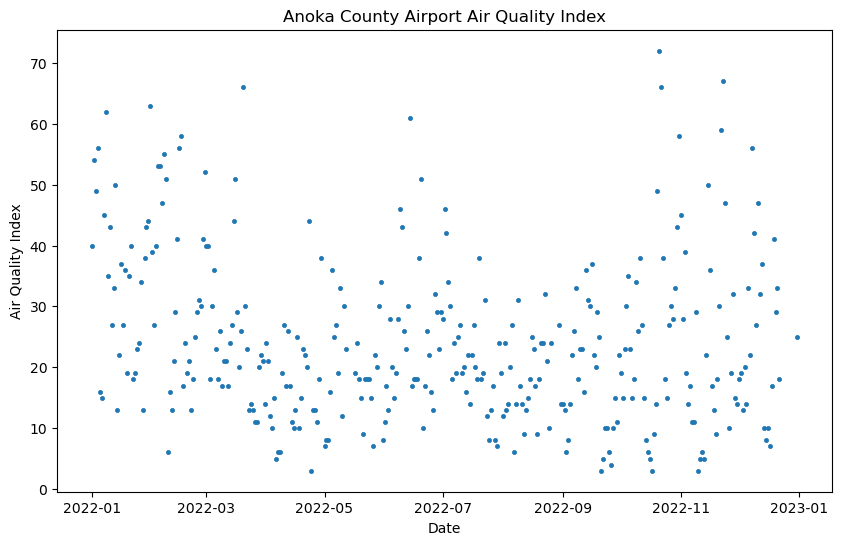

In [17]:
# Graph Anoka County Airport AQI
plt.figure(figsize=(10, 6))
x_values = anoka_2022_pm25_daily["Date"]
y_values = anoka_2022_pm25_daily["Daily_AQI"]
plt.scatter(x_values, y_values, linewidth = 0.5, marker = '.')

plt.title("Anoka County Airport Air Quality Index")
plt.xlabel("Date")
plt.ylabel("Air Quality Index")


plt.show()

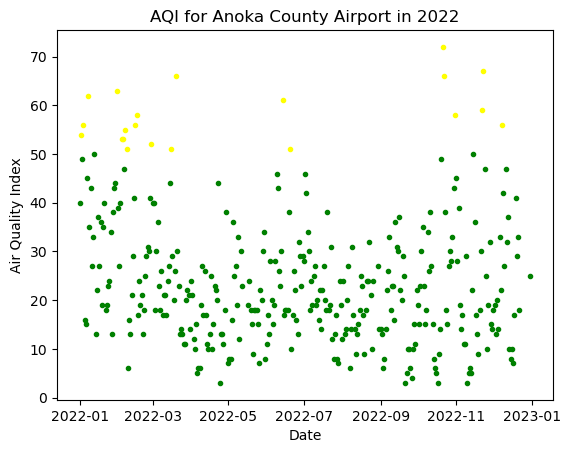

In [61]:
# Make color-coded scatter plot for Anoka County Airport
moderate_bound = 50
unhealthy_for_special_groups_bound = 100
unhealthy_bound = 150
very_unhealthy_bound = 200
hazardous_bound = 300

x = anoka_2022_pm25_daily["Date"]
y = anoka_2022_pm25_daily["Daily_AQI"]

good = np.ma.masked_where(y > moderate_bound, y)
moderate = np.ma.masked_where((y <= moderate_bound) | (y > unhealthy_for_special_groups_bound), y)
unhealthy_special_groups = np.ma.masked_where((y <= unhealthy_for_special_groups_bound) | (y > unhealthy_bound), y)
unhealthy = np.ma.masked_where((y <= unhealthy_bound) | (y > very_unhealthy_bound), y)
very_unhealthy = np.ma.masked_where((y <= very_unhealthy_bound) | (y > hazardous_bound), y)
hazardous = np.ma.masked_where(y <= hazardous_bound, y)

fig, ax = plt.subplots()
ax.scatter(x, good, color = 'green', marker = '.')
ax.scatter(x, moderate, color = 'yellow', marker = '.')
ax.scatter(x, unhealthy_special_groups, color = 'orange', marker = '.')
ax.scatter(x, unhealthy, color = 'red', marker = '.')
ax.scatter(x, very_unhealthy, color = 'purple', marker = '.')
ax.scatter(x, hazardous, color = 'maroon', marker = '.')

plt.xlabel("Date")
plt.ylabel("Air Quality Index")
plt.title("AQI for Anoka County Airport in 2022")

plt.show()